## Trabalho Prático 2 de DL-PLN

**Nome:** Antônio Caetano Neves Neto

**Matrícula:** 2022043698

O objetivo do seguinte relatório é mostrar verificar a execução de um modelo Finetuning para a tarefa de POS Tagging para a língua portuguesa, cujo objetivo é rotular cada palavra de um texto com sua respectiva classe gramatical, usando o corpus Mac-Morpho. Assim, será utilizado a seguinte estratégia:

* Finetuning: com um modelo já treinado para a tarefa, baseado na arquitetura BERT, é feito a mesma predição dos casos de teste e analisado os resultados.

Assim, com esse trabalho será possível entender como o modelo correlaciona os diversos fatores que envolve a língua, e entender que o problema de POS Tagging é extremamente difícil, dado a enorme variação que a língua portuguesa possui.

### Importação

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_theme(style="whitegrid")

Como já há um modelo pronto e feito o finetuning para a tarefa, será utilizado ele.

In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline


finetunig_tokenizer = AutoTokenizer.from_pretrained("lisaterumi/postagger-portuguese")
finetunig_model = AutoModelForTokenClassification.from_pretrained("lisaterumi/postagger-portuguese")

finetuning_pipe = pipeline("token-classification", model=finetunig_model, tokenizer=finetunig_tokenizer)

Device set to use cpu


### Leitura dos dados

Os dados são do corpo macmorpho, no qual é composto dos dados de treino, validação e teste. Contudo, como o modelo já foi pré-treinado, será utilizado somente os dados de teste nesse relatório.

In [3]:
def read_of_data(source):
    with open(source, "r", encoding="utf-8") as src:
        data = src.read().split("\n")

    tokens = []
    for line in data:
        if line != "":
            tokens.append(line.split(" ")) 

    pairs_for_line = []
    for line in tokens:
        v = [token.split("_") for token in line]
        pairs_for_line.append(v)

    return pairs_for_line

In [4]:
train_data = read_of_data("macmorpho-v3/macmorpho-train.txt")
dev_data = read_of_data("macmorpho-v3/macmorpho-dev.txt")
test_data = read_of_data("macmorpho-v3/macmorpho-test.txt")

### Fine-Tuning

Com o uso do pipeline importado, é retornado por token qual a classe gramatical predita e o seu score. Contudo, a tokenização há um certo problema em dividir uma palavra em dois tokens, o que propaga um erro se utilizar a saída no seu estado "cru", resultando em baixas acurácias. A função de truncagem trata essa questão, ao verificar se a palavra foi cortada e, se sim, verifica qual das duas subpartes obteve o maior score.

#### Execução

In [5]:
# Necessário ter essa função, pois de vez em quando o tokenizer divide uma palavra quando não deve
def truncate_prediction(predictions):
    filtered = [predictions[0]]

    for prediction in predictions[1:]:
        if "##" in prediction["word"]:
            last = filtered[-1]
            filtered[-1] = last if last["score"] >= prediction["score"] else prediction
        else:
            filtered.append(prediction)

    return [pred["entity"] for pred in filtered]

In [6]:
predictions = []
labels = []

for line in tqdm(test_data):
    sentence = " ".join([word for word, _ in line])
    tags = [tag for _, tag in line]

    preds = truncate_prediction(finetuning_pipe(sentence))

    if len(tags) < len(preds):
        preds = preds[:len(tags)]
    elif len(tags) > len(preds):
        preds = preds + ["<pad>"] * (len(tags) - len(preds))

    labels.extend(tags)
    predictions.extend(preds)

100%|██████████| 9987/9987 [18:14<00:00,  9.12it/s]


#### Avaliação

Para a avaliação, será avaliado a acurácia e o F1 score, além de determinadas análises como matriz de confusão e quais classes gramaticas obtiveram o maior número de erros.

In [7]:
info = pd.DataFrame(np.array([labels, predictions]).T, columns=["label", "pred"])

##### Métricas

In [8]:
accuracy = accuracy_score(labels, predictions)
f1 = f1_score(labels, predictions, average='macro')

print("Accuracy Score:", accuracy)
print("F1 Score (Macro Average):", f1)

Accuracy Score: 0.8650412338190197
F1 Score (Macro Average): 0.8004705348507606


##### Quais as classes que possuem mais erro?

Aqui é analisado duas abordagens: uma não normalizada e outra normalizada. Mas o fim é o mesmo, verificar quais classes tiveram a maior contagem de predições erradas.

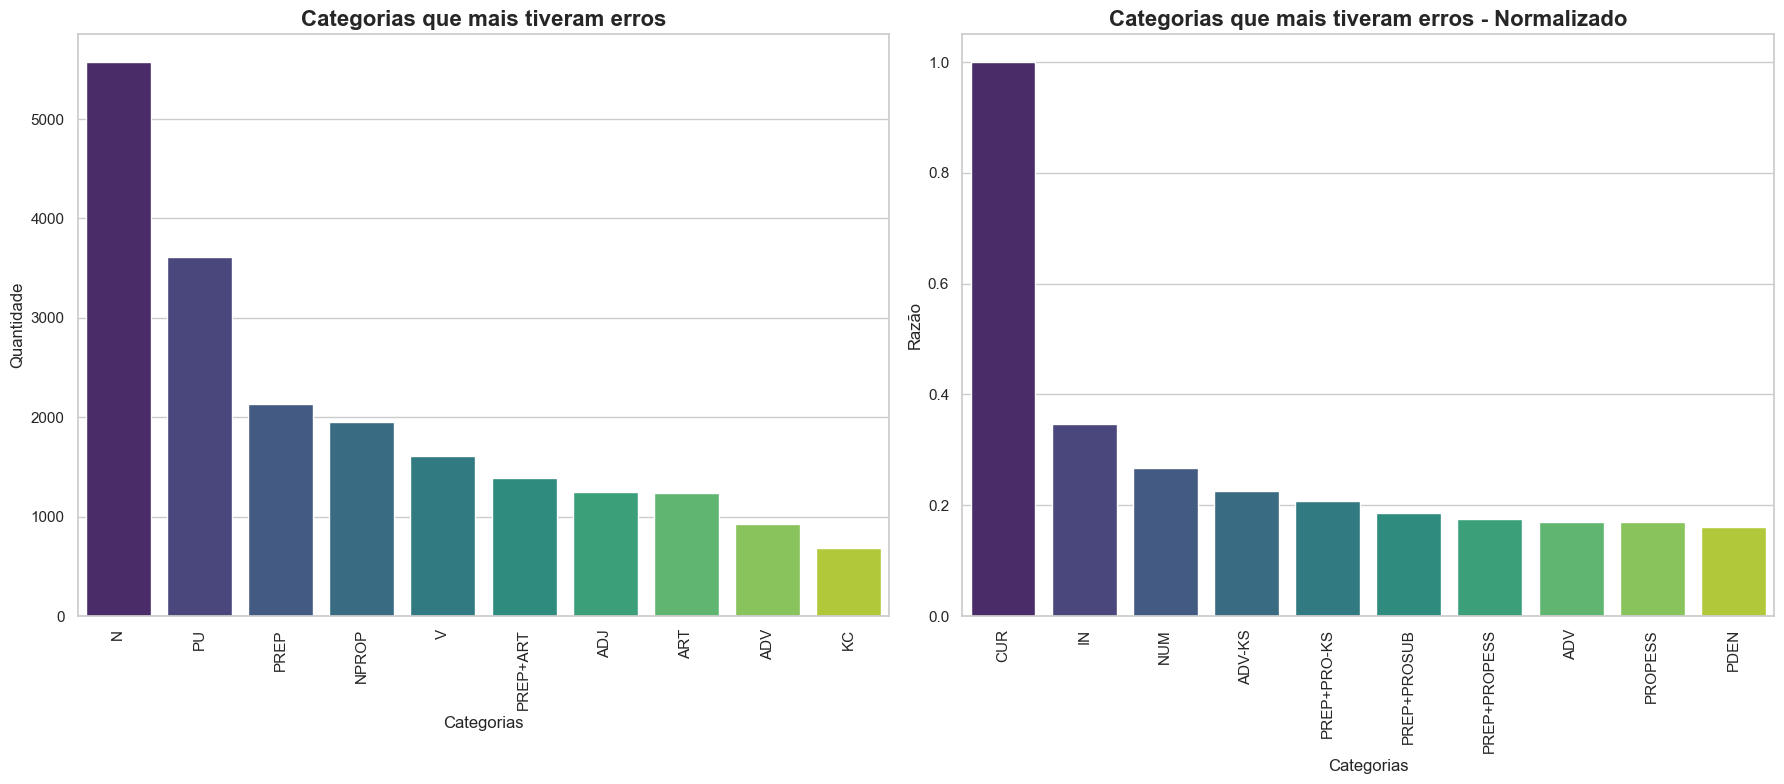

In [9]:
fig, axis = plt.subplots(1, 2, figsize=(18, 8))

df = info[info["label"] != info["pred"]].groupby("label").count().sort_values(by="pred", ascending=False).head(10).reset_index()

sns.barplot(data=df, x='label', y='pred', palette='viridis', ax=axis[0])

axis[0].set_title('Categorias que mais tiveram erros', fontsize=16, fontweight='bold')
axis[0].set_xlabel('Categorias', fontsize=12)
axis[0].set_ylabel('Quantidade', fontsize=12)


df = info[info["label"] != info["pred"]].groupby("label").count().reset_index()
df["pred"] = df["pred"].values / info.groupby("label").count().loc[df["label"], "pred"].values
df = df.sort_values(by="pred", ascending=False).head(10)

sns.barplot(data=df, x='label', y='pred', palette='viridis', ax=axis[1])

axis[1].set_title('Categorias que mais tiveram erros - Normalizado', fontsize=16, fontweight='bold')
axis[1].set_xlabel('Categorias', fontsize=12)
axis[1].set_ylabel('Razão', fontsize=12)

for ax in axis:
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

plt.tight_layout()
plt.show()

Quando trata-se de erro sem normalização, os substantivos dominam, mas dado a sua quantidade presente nas frases, sendo o mais frequente. A mesma forma é visto com pontuação e preposição. Agora, ao normalizar os erros, dividindo pela quantidade de vezes que a classe aparece, moeda aparece com uma taxa de 100% de erro. Ao visualizar a sentença, uma das hipóteses seria dado a variação que moedas podem ter, e até mesmo ser confundido com números, o tokenizer não deve tratar da forma correta, podendo ser melhorado. A segunda com maior número de erro normalizado é a interjeição, chegando perto de 40%.

##### Precisão por classe gramatical

A partir da métrica de precisão, é ordenado e visualizado a precisão por classe.

c:\Users\tonim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


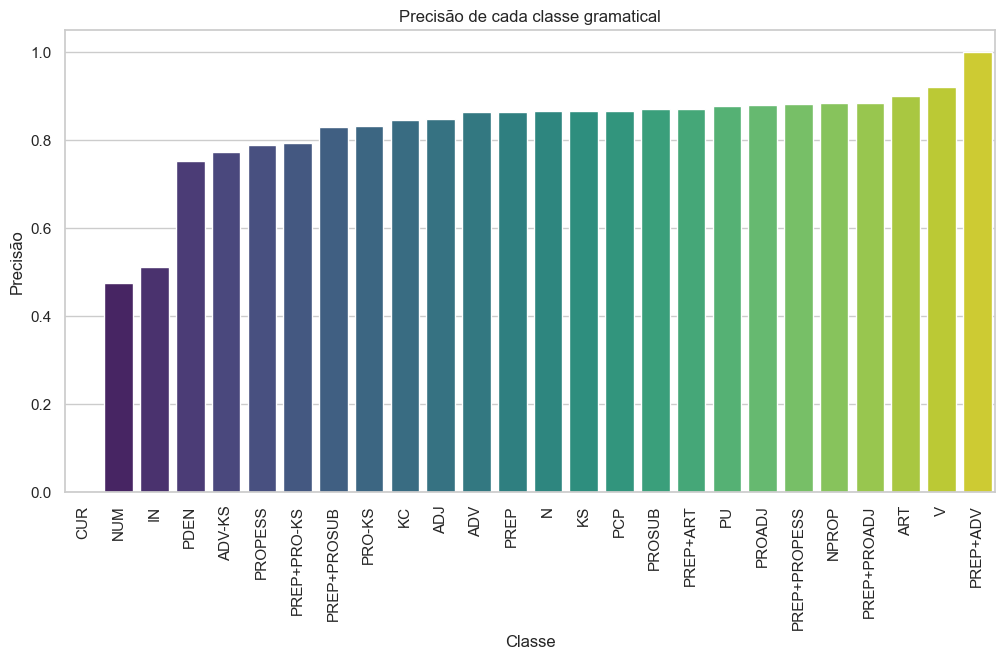

In [10]:
classes = sorted(set(labels))
precision_per_class = precision_score(labels, predictions, average=None, labels=classes)

df_precision = pd.DataFrame({
    'Class': classes,
    'Precision': precision_per_class
}).sort_values("Precision", ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(data=df_precision, x='Class', y='Precision', palette='viridis', ax=ax)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

ax.set_title("Precisão de cada classe gramatical")
ax.set_xlabel("Classe")
ax.set_ylabel("Precisão")

plt.show()

Percebe-se que preposições com advérbio, verbos e artigos são bem mais fáceis de prever que as demais, com a primeira falada chegando a ter 100% de precisão. Isso se dá pela pouca variabilidade (no caso de artigo e preposição com advérbios), no caso o conjunto de palavras que se encaixam nessa classe gramatical é baixo em relação as demais e não pertencem a outras classes dependendo do sentido da frase. Verbos significa que o modelo aprendeu bem a relação do mesmo no contexto, principalmente em relação aos sufixos, o que significa que se a tarefa fosse expandida para prever também as subclasses de verbo, o modelo poderia aprender bem também.

Moeda e números foram as classes com menor precisão. Uma hipótese para tal observação é a grande variabilidade que moedas e números possuem, dado que são infinitos, então talvez durante o processo de tokenização, alguns números podem se perder ou confundir palavras que pertence a outras classes com número.

Outros destaques negativos são interjeições e palavra denotativa.

Outra observação também é a precisão da pontuação. O que acaba a ser estranho, devido que há pouca variabilidade e é fácil de ser predita. O modelo confundiu outras classes com pontuação, podendo ser, em hipótese, um problema na geração dos tokens.

Cabe lembrar que o tokenizer estava dividindo as palavras em duas, e foi até feito um processo de truncagem na saída. Assim, isso pode ter atrapalhado na predição de diversas palavras.

##### Matriz de confusão

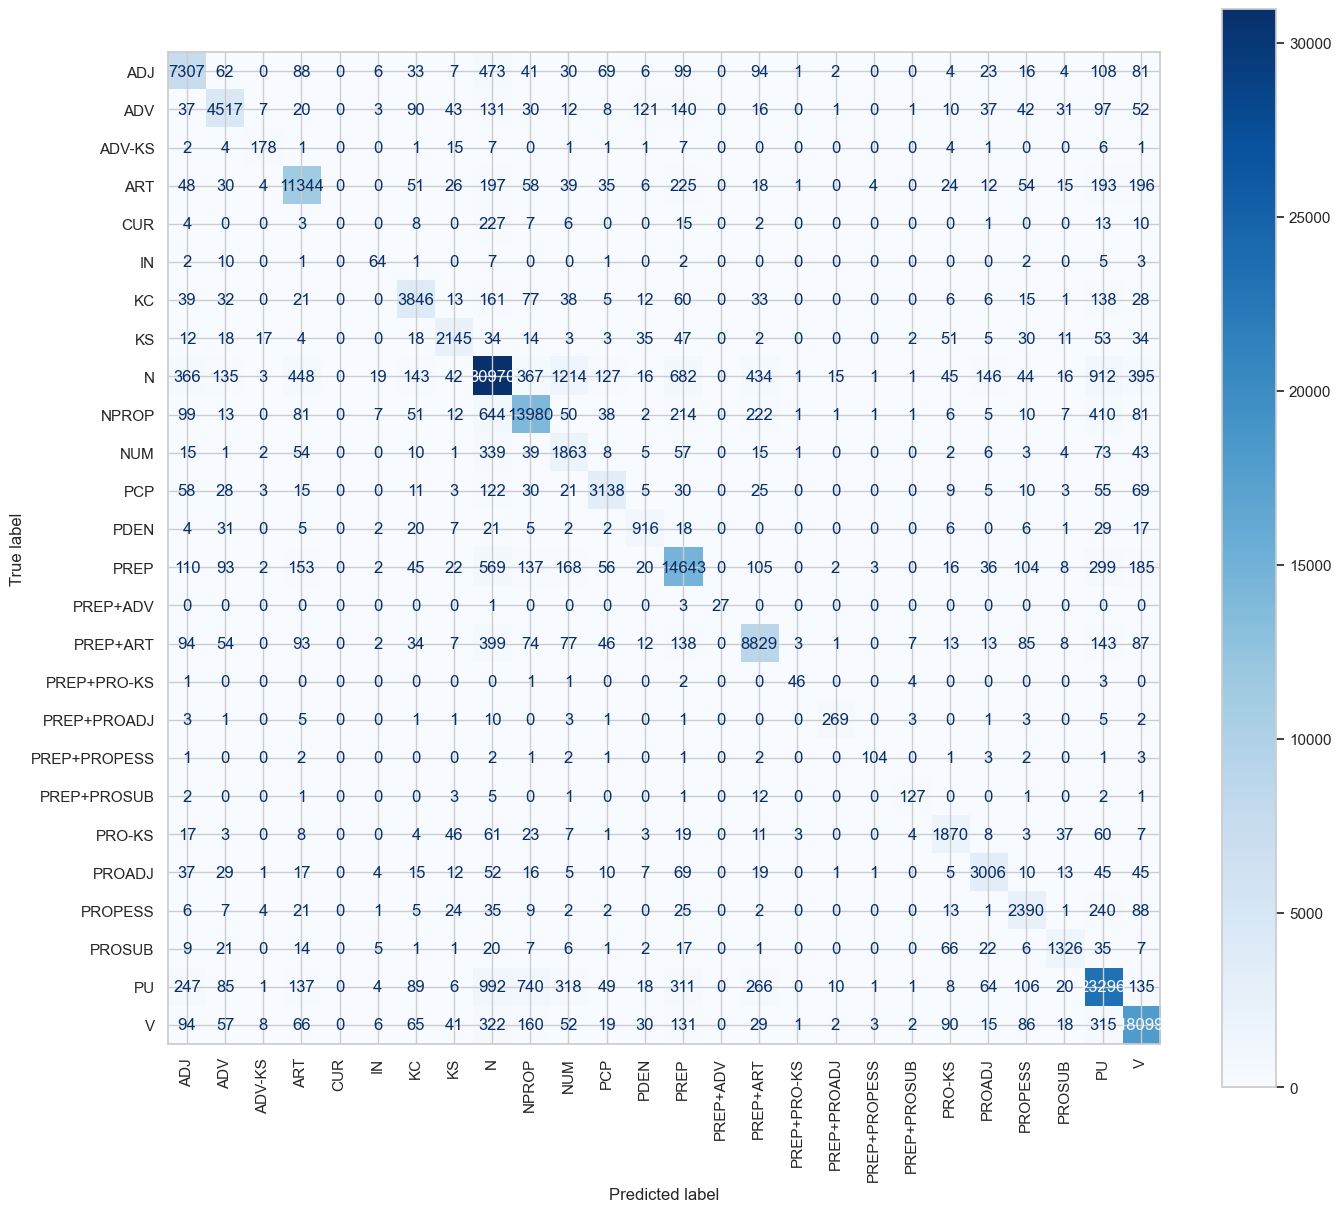

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(labels, predictions)
fig, ax = plt.subplots(1, 1, figsize=(16, 14))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(labels)))
disp.plot(cmap="Blues", ax=ax) 
plt.xticks(rotation=90)
plt.show()

Na matriz de confusão, é possível notar que moeda foi confundido com nome, chegando perto de 80% do erro total. Além disso, nome foi confundido por diversas outras classes, mas sua quantidade é bem maior que a de qualquer outra classe, podendo criar um viés no modelo de apostar mais que uma palavra é substantivo.

Em contrapartidam, a pouca quantidade de preposições com advérbios e mesmo assim o modelo teve alta precisão. Logo, se diferenciou bem de substantivo e outras classes mais numerosas, com o modelo aprendendo bem suas nuances.

### Conclusão

No trabalho foi possível analisar as nuances que envolve o uso de modelos de transformers na tarefa de POS Tagging. No relatório, nota-se que a língua é um assunto complexo, que envolve diversos aspectos e contexto acaba sendo primordial. O modelo que vem de um finetuning do BERT se deu relativamente bem na tarefa, aprendendo a classificar diversas classes gramaticais de forma correta e com uma precisão alta, como verbos, artigos e preposições com advérbios. Ao mesmo tempo, quando se trata de números na linguagem, o modelo apresenta falhas e problemas.